<span style="color:green; font-size:50px; font-weight:bold;">**BCARD MODELING**</font> 

# 1. Import libraries and sampling

## 1.1. Import libraries

In [1]:
# Import lib and data
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
from tqdm_joblib import tqdm_joblib
from optbinning import OptimalBinning
from tqdm import tqdm
import polars as pl
import itertools

warnings.filterwarnings("ignore", category=DeprecationWarning)

#warnings.filterwarnings('ignore')
os.chdir("E:/1. Bcard/Result/logistic result/20250429_segment_làm_tròn/Segment 3 fixed 3")

C:\Users\dungpt23\AppData\Roaming\Python\Python310\site-packages\tqdm_joblib\__init__.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


(CVXPY) May 19 01:43:23 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.11.4210). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) May 19 01:43:23 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.11.4210). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')


## 1.2. Import data and sampling

In [2]:
# Import dữ liệu lớn bằng Polars
file_pl = pl.read_parquet('F:/DELOITTE_TEMP_DB/segment_3_v3.parquet')

# Import var names, groups and expected sign
var_names  = pd.read_excel('./Long list.xlsx')

var_names['Type']= var_names['Variable Type'].replace({'numerical':'q','categorical':'c'})

# Loại bỏ cột định nghĩa KH tốt/xấu
default_var_names = var_names[var_names['Group'].isin(['Định nghĩa khách hàng xấu/tốt', 'Thông tin kinh tế vĩ mô'])]['Variable'].to_list()

file_pl = file_pl.drop(default_var_names)  

In [3]:
# Tạo thêm cột year & month
file_pl = file_pl.with_columns([pl.col('datadate').dt.year().alias('year'), pl.col('datadate').dt.month().alias('month')])

# Xác định month đầu tiên mỗi SOCIF xuất hiện
month_first_df = file_pl.group_by('SOCIF').agg(month_first = pl.col('datadate').min().dt.month())

# Join vào để biết month_first của từng SOCIF
file_pl = file_pl.join(month_first_df, on='SOCIF', how='left')

# Lấy record theo logic:
# - Nếu có month_first trong năm thì lấy min datadate của month đó
# - Không thì lấy min datadate của năm đó
subsampled_df = file_pl.group_by(['SOCIF', 'year']).agg([pl.when(pl.col('month') == pl.col('month_first'))
                                                         .then(pl.col('datadate').min())
                                                         .otherwise(pl.col('datadate').min())
                                                         .alias('selected_date')
                                                         ])

# Join lại để lấy full record
subsampled_df = file_pl.join(subsampled_df,on=['SOCIF', 'year', 'datadate' == 'selected_date'],how='inner')

# Split OOT 2022
oot_data = subsampled_df.filter(pl.col('year') == 2022)

# Split 2018-2021
subsampled_df_18_21 = subsampled_df.filter((pl.col('year') > 2017) & (pl.col('year') < 2022))

In [ ]:
# Xử lý SOCIF & datadate
#first_apperance = file_pl.group_by('SOCIF').agg(pl.min('datadate').alias('first_date'))
#first_apperance = first_apperance.with_columns(pl.col('first_date').dt.month().alias('month'))
#file_pl = file_pl.with_columns(pl.col('datadate').dt.month().alias('month'))

# Chọn mẫu dữ liệu sau 2017
#subsampled_df = file_pl.filter(pl.col('datadate').dt.year() > 2017)
#subsampled_df = subsampled_df.join(first_apperance[['SOCIF', 'month']], on=['SOCIF', 'month'], how='inner').drop('month')

# Chia tập Train/Test/OOT
#oot_data = subsampled_df.filter(pl.col('datadate').dt.year() == 2022)  # Test set 2022
#subsampled_df_18_21 = subsampled_df.filter((pl.col('datadate').dt.year() > 2017) & (pl.col('datadate').dt.year() < 2022))

In [4]:
len(subsampled_df.filter(pl.col('BAD') == 1))/len(file_pl)

0.009588319167562092

In [5]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(subsampled_df_18_21.drop(['BAD']), subsampled_df_18_21['BAD'],
                                                    test_size=0.2, random_state= 6969, stratify=subsampled_df_18_21['BAD']
                                                    )
# Tạo tập out of time
X_oot = oot_data.drop(['BAD'])
y_oot = oot_data['BAD']

In [8]:
drop_list = ['C_GIOITINH', 'TUOI', 'TRINHDO', 'TTHONNHAN', 'SOHUUNHA',
             'final_CST_MKT_SEG', 'PDKH', 'PURCOD_MAX', 'PURCOD_MIN', 
             'final_CST_MKT_SEG', 'PDKH', 'year', 'month', 'month_first', 
             'SOCIF_right', 'year_right', 'selected_date','__index_level_0__', 
             'RATE_AVG', 'N_NHOM2_CBAL','N_NHOM3_CBAL' ]

X_train = X_train.drop(drop_list)
X_test = X_test.drop(drop_list)
X_oot = X_oot.drop(drop_list)

In [9]:
X_train.shape

(1901028, 221)

In [10]:
len(y_train)

1901028

In [11]:
X_train.columns

['datadate',
 'SOCIF',
 'CBALORG',
 'CBALORG_AVG',
 'CBALORG_MAX',
 'CBALORG_MIN',
 'CBAL',
 'CBAL_AVG',
 'CBAL_MAX',
 'CBAL_MIN',
 'NHANVIENBIDV',
 'AFLIMT_SUM',
 'AFLIMT_MAX',
 'AFLIMT_MIN',
 'AFLIMT_AVG',
 'DURATION_AVG',
 'DURATION_MAX',
 'DURATION_MIN',
 'REMAINING_DURATION_AVG',
 'REMAINING_DURATION_MAX',
 'REMAINING_DURATION_MIN',
 'TIME_TO_OP_AVG',
 'TIME_TO_OP_MAX',
 'TIME_TO_OP_MIN',
 'RATE_MAX',
 'RATE_MIN',
 'PRINPICAL_PYMT_FRQ_ID_MAX',
 'INT_PYMT_FRQ_ID_MAX',
 'PRINPICAL_PYMT_FRQ_ID_MIN',
 'INT_PYMT_FRQ_ID_MIN',
 'CFORGD',
 'FLAG_SALARY_ACC',
 'LTV',
 'MAX_LTV_MO',
 'MIN_LTV_MO',
 'AVG_LTV_MO',
 'N_G_LTV_3M',
 'N_G_LTV_6M',
 'N_G_LTV_9M',
 'N_G_LTV_12M',
 'N_MIN_LTV',
 'N_MAX_LTV',
 'N_AVG_LTV',
 'INCOME',
 'CBAL_TO_INC_3MON',
 'CBAL_TO_INC_6MON',
 'CBAL_TO_INC_9MON',
 'CBAL_TO_INC_12MON',
 'FLAG_DEPOSIT',
 'N_AVG_CD_3M',
 'N_AVG_CD_6M',
 'N_AVG_CD_9M',
 'N_AVG_CD_12M',
 'N_MAX_CD_CBAL',
 'N_MIN_CD_CBAL',
 'N_AVG_CD_CBAL',
 'N_AVG_DD_3M',
 'N_AVG_DD_6M',
 'N_AVG_DD_9M',
 '

In [12]:
X_train.write_parquet('./X_train.parquet')
X_test.write_parquet('./X_test.parquet')
X_oot.write_parquet('./X_oot.parquet')
pl.DataFrame(y_train).write_parquet('./y_train.parquet')
pl.DataFrame(y_test).write_parquet('./y_test.parquet')
pl.DataFrame(y_oot).write_parquet('./y_oot.parquet')

# 2. Univariate analysis

## 2.1. Binning and rebinning

### 2.1.1. Binning process

In [13]:
var_names['Sign'] = var_names['Expected sign'].replace([1, -1, 0], ['ascending', 'descending', 'auto'])

var_names

,STT,Variable,Name,Logic tính toán,Group,Variable Type,Expected sign,Notes,Type,Sign
0,1,datadate,Ngày thực hiện quan sát,Thời điểm quan sát,Thông tin chung,NaN,NaN,NaN,NaN,NaN
1,2,SOCIF,Mã khách hàng (CIF),Số CIF Khách hàng,Thông tin chung,NaN,NaN,NaN,NaN,NaN
2,3,CBALORG,Tổng dư nợ gốc tại thời điểm quan sát,Tổng dư nợ gốc cộng theo cấp khách hàng tại th...,Thông tin chung,numerical,1.0,NaN,q,ascending
3,4,CBALORG_AVG,Dư nợ gốc trung bình của khoản vay còn hoạt độ...,Dư nợ gốc trung bình của khách hàng tại thời đ...,Thông tin chung,numerical,1.0,NaN,q,ascending
4,5,CBALORG_MAX,Dư nợ gốc lớn nhất của khoản vay còn hoạt động...,Dư nợ gốc lớn nhất của khách hàng tại thời điể...,Thông tin chung,numerical,1.0,NaN,q,ascending
...,...,...,...,...,...,...,...,...,...,...
277,278,NHOMNOCUOI_PREV,Nhóm nợ theo kết quả phân loại nợ tại BIDV,Nhóm nợ theo kết quả phân loại nợ tại BIDV,Định nghĩa khách hàng xấu/tốt,NaN,NaN,NaN,NaN,NaN
278,279,NHOMNOCUOI_CUR,Nhóm nợ theo kết quả phân loại nợ tại BIDV,Nhóm nợ theo kết quả phân loại nợ tại BIDV,Định nghĩa khách hàng xấu/tốt,NaN,NaN,NaN,NaN,NaN
279,280,NHOMNOCIC,Nhóm nợ theo kết quả phân loại nợ tại CIC,Nhóm nợ theo kết quả phân loại nợ tại CIC,Định nghĩa khách hàng xấu/tốt,NaN,NaN,NaN,NaN,NaN
280,281,NHOMNOCUOI,Nhóm nợ theo kết quả phân loại nợ tại BIDV,Nhóm nợ theo kết quả phân loại nợ tại BIDV,Định nghĩa khách hàng xấu/tốt,NaN,NaN,NaN,NaN,NaN


In [14]:
# danh sách các biến overdue
od_var = ['SUM_ALL_OD_3M', 'SUM_ALL_OD_6M', 'SUM_ALL_OD_9M', 'SUM_ALL_OD_12M', 'MAX_AFCPNO_OD_3M', 'MAX_AFCPNO_OD_6M', 
          'MAX_AFCPNO_OD_9M', 'MAX_AFCPNO_OD_12M', 'MIN_AFCPNO_OD_3M', 'MIN_AFCPNO_OD_6M', 'MIN_AFCPNO_OD_9M', 'MIN_AFCPNO_OD_12M', 
          'AVG_AFCPNO_OD_3M', 'AVG_AFCPNO_OD_6M', 'AVG_AFCPNO_OD_9M', 'AVG_AFCPNO_OD_12M', 'SUM_31D_60D_OD_12M', 'SUM_61D_90D_OD_12M', 
          'MAX_31D_60D_OD_12M', 'MAX_61D_90D_OD_12M', 'MIN_31D_60D_OD_12M', 'MIN_61D_90D_OD_12M']

# Danh sách các biến hiển thị kém
digit_var = ['RATE_AVG','RATE_MAX','RATE_MIN', 'N_G_LTV_3M', 
             'N_G_LTV_6M', 'N_G_LTV_9M', 'N_G_LTV_12M', 
             'N_MIN_DEPOSIT_CBAL', 'N_MIN_PYMTAMT_9M', 'N_MIN_PYMTAMT_12M']

binning_table = pd.DataFrame()

# Vòng lặp
for feature in X_train[:, 2:].columns:
    # Lấy thông tin biến
    trend = var_names.loc[var_names["Variable"] == feature, "Sign"].values[0]
    dtype =  var_names.loc[var_names["Variable"] == feature, "Variable Type"].values[0]

    if feature in od_var:
        none = [0]
    else:
        none = None

    # Binning với optbinning
    opt_binner = OptimalBinning(prebinning_method= "cart", 
                                dtype= dtype, solver= "cp",
                                max_n_bins= 5, 
                                max_bin_size= 0.9, 
                                min_bin_size= 0.05,
                                monotonic_trend= trend, 
                                random_state= 6969, 
                                special_codes = none
                                )
    opt_binner.fit(X_train.select(feature).to_numpy().ravel(), y_train.to_numpy().ravel())

    # Map data với woe đã chia
    X_train = X_train.with_columns(pl.Series(feature, opt_binner.transform(X_train[feature].to_numpy(), metric="woe")))  
    X_test = X_test.with_columns(pl.Series(feature, opt_binner.transform(X_test[feature].to_numpy(), metric="woe")))  
    X_oot = X_oot.with_columns(pl.Series(feature, opt_binner.transform(X_oot[feature].to_numpy(), metric="woe"))) 

    # Lưu bảng binning
    if feature in digit_var:
        show_digits = 5
    else:
        show_digits = 2

    # Lấy bảng binning
    bin = pd.DataFrame(opt_binner.binning_table.build(show_digits= show_digits))
    bin['Feature'] = feature

    if feature in od_var:
        bin = bin.iloc[:-2]
    else:
        bin = bin.iloc[:-3]
    
    if dtype == 'numerical':
        bin[["Lower bin", "Upper bin"]] = (bin["Bin"].astype(str).str.replace(r"[\[\]\(\)]", "", regex=True).str.split(",", expand=True))
        bin[["Lower bin", "Upper bin"]] = (bin[["Lower bin", "Upper bin"]].replace({"-inf": -np.inf, "inf": np.inf}))   
    else:
        bin["Lower bin"] = bin["Bin"]
        bin["Upper bin"] = bin["Bin"]

    # Tính thêm thông tin
    bin['% Good'] = bin['Non-event'] / (y_train.to_numpy() == 0).sum()
    bin['% Bad'] = bin['Event'] / (y_train.to_numpy() == 1).sum()
    bin['max_perc'] = bin['Count (%)'].max()
    bin['min_perc'] = bin['Count (%)'].min()
    bin['Total IV'] = bin['IV'].sum()
    bin['Bin number'] = bin.index + 1
    bin['Bad rate diff'] = (bin['Event rate'] - bin['Event rate'].shift(-1)).abs()
    bin['Rebin'] = bin['Bad rate diff'] < 0.006
    
    #woe_mean = (bin['WoE'] * bin['Count (%)']).sum()
    #std_woe = np.sqrt(((bin['WoE'] - woe_mean) ** 2 * bin['Count (%)']).sum())

    #if std_woe == 0:
    #    bin['Normalized WoE'] = 0 
    #else:
    #    bin['Normalized WoE'] = (bin['WoE'] - woe_mean) / std_woe

    bin.rename(columns={'Count (%)':'Share','Non-event': 'Good','Event': 'Bad','Event rate': 'Bad rate'}, inplace= True)
    
    # Lưu kết quả
    bin = bin[['Feature', 'Bin number', 'Bin', 
               'Count', 'Share', 'Good', 'Bad', 
               'Bad rate','% Good', '% Bad', 'max_perc', 'min_perc', 'WoE', 'IV', 'Total IV',
               'Bad rate diff', 'Rebin', 'Lower bin', 'Upper bin']]

    binning_table = pd.concat([binning_table, bin], ignore_index=True)

C:\Users\dungpt23\AppData\Local\Temp\ipykernel_23128\25483205.py:59: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  bin[["Lower bin", "Upper bin"]] = (bin[["Lower bin", "Upper bin"]].replace({"-inf": -np.inf, "inf": np.inf}))
C:\Users\dungpt23\AppData\Local\Temp\ipykernel_23128\25483205.py:59: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  bin[["Lower bin", "Upper bin"]] = (bin[["Lower bin", "Upper bin"]].replace({"-inf": -np.inf, "inf": np.inf}))
C:\Users\dungpt23\AppData\Local\Temp\ipykernel_23128\25483205.py:59: FutureWarning: Do

### 2.1.2. Rebin valid feature

Với các biến binning đạt tiêu chí IV >= 0.02 nhưng sự khác biệt giữa các bin quá ít (< 0.6% = 0.006) -> Xem xét gộp những bin tương đồng như vậy lại với nhau

* Flow gộp:
* 1. Lấy ra các biến có total IV >= 0.02 cần gộp
* 2. Thực hiện gộp các bin cần gộp của biến đó
* 4. Nếu total IV vẫn >= 0.02 và số lượng quan sát của bin lớn nhất <= 0.9 -> thay thế bin mới; nếu failed 1 trong 2 điều kiện kia -> giữ nguyên bin cũ

In [15]:
# Check biến có total IV > 0.02
valid_feat = binning_table[binning_table['Total IV'] >=0.02]

# Lên danh sách các bin cần rebin
rebin = valid_feat[valid_feat["Rebin"] == True]

# List các bin ngay dưới bị phải bin lại (cũng là các bin bị ghép)
rebin_shift = valid_feat[valid_feat.index.isin(rebin.index + 1)]

# Ghép lại để lấy danh sách rebin full
rebin_list = pd.concat([rebin, rebin_shift])
# Đổi kiểu data
rebin_list['Upper bin'] = rebin_list['Upper bin'].astype(float)
rebin_list['Lower bin'] = rebin_list['Lower bin'].astype(float)
rebin_list['Bin'] = rebin_list['Bin'].astype(str)

# Drop những bin bị lặp
rebin_list = rebin_list.drop_duplicates().sort_values(['Feature', 'Bin number']).reset_index().drop('index', axis= 1)

# Lấy và bỏ đi những biến bị rebin toàn bộ
rebin_count = rebin_list[['Feature', 'Bin number']].groupby('Feature').agg('count')
bin_count = binning_table[['Feature', 'Bin number']].groupby('Feature').agg('count')

# Check nếu số bị phải rebin = tổng số bin của df bin gốc -> loại ra
check = bin_count.merge(rebin_count, how='left', on= 'Feature').reset_index().dropna()
check['check'] = check['Bin number_x'] ==  check['Bin number_y']
check_feat = check[check['check'] == True]['Feature'].tolist()

# Drop 
final_rebin_list = rebin_list[~rebin_list['Feature'].isin(check_feat)]

In [16]:
rebin['Feature'].unique()

array(['CBALORG', 'CBALORG_AVG', 'CBALORG_MAX', 'CBALORG_MIN', 'CBAL',
       'CBAL_AVG', 'CBAL_MAX', 'CBAL_MIN', 'DURATION_AVG', 'DURATION_MAX',
       'DURATION_MIN', 'REMAINING_DURATION_AVG', 'REMAINING_DURATION_MAX',
       'REMAINING_DURATION_MIN', 'RATE_MAX', 'PRINPICAL_PYMT_FRQ_ID_MAX',
       'PRINPICAL_PYMT_FRQ_ID_MIN', 'CFORGD', 'LTV', 'MAX_LTV_MO',
       'MIN_LTV_MO', 'AVG_LTV_MO', 'N_G_LTV_3M', 'N_G_LTV_6M',
       'N_G_LTV_9M', 'N_G_LTV_12M', 'N_MIN_LTV', 'N_MAX_LTV', 'N_AVG_LTV',
       'INCOME', 'CBAL_TO_INC_3MON', 'CBAL_TO_INC_6MON', 'N_AVG_CD_3M',
       'N_AVG_CD_6M', 'N_AVG_CD_9M', 'N_AVG_CD_12M', 'N_MAX_CD_CBAL',
       'N_MIN_CD_CBAL', 'N_AVG_CD_CBAL', 'N_AVG_DD_3M', 'N_AVG_DD_6M',
       'N_AVG_DD_9M', 'N_AVG_DD_12M', 'N_MAX_DD_CBAL', 'N_MIN_DD_CBAL',
       'N_AVG_DD_CBAL', 'N_AVG_DEPOSIT_3M', 'N_AVG_DEPOSIT_6M',
       'N_AVG_DEPOSIT_9M', 'N_AVG_DEPOSIT_12M', 'N_MAX_DEPOSIT_CBAL',
       'N_MIN_DEPOSIT_CBAL', 'N_AVG_DEPOSIT_CBAL', 'HAS_LONGTERM_LOAN',
       'C

In [17]:
# Bắt đầu gộp bin
binning_table_1 = binning_table.copy()

for i in final_rebin_list["Feature"].unique():
    # Lấy các bin cần gộp
    rebin_df = final_rebin_list[final_rebin_list['Feature'] == i]

    # Các bin KHÔNG bị rebin của cùng biến đó 
    non_rebin = binning_table[
        (binning_table['Feature'] == i) &
        (~binning_table['Bin'].isin(rebin_df['Bin']))
    ]

    # Tạo data
    merged_label = f"[{rebin_df.iloc[0]['Lower bin']}, {rebin_df.iloc[-1]['Upper bin']})"
    bin_number = rebin_df["Bin number"].max()
    count = rebin_df['Count'].sum()
    share = float(count) / len(y_train)

    good = rebin_df['Good'].sum()
    bad = rebin_df['Bad'].sum()
    bad_total = (y_train == 1).sum()
    good_total = (y_train == 0).sum()

    perc_good = good / good_total
    perc_bad = bad / bad_total

    # WoE và IV
    woe = np.log((perc_bad + 1e-6) / (perc_good + 1e-6))  # thêm epsilon để tránh log(0)
    iv = (perc_bad - perc_good) * woe
    total_iv = float(iv) + float(non_rebin['IV'].sum())

    # Xét điều kiện
    if total_iv >= 0.1 and share <= 0.9:
        # Xoá các bin cũ
        drop_idx = binning_table_1[(binning_table_1['Feature'] == i) &
                                   (binning_table_1['Bin'].isin(rebin_df['Bin']))
                                   ].index
        binning_table_1 = binning_table_1.drop(index=drop_idx).reset_index(drop=True)

        # Tạo bin mới
        rebin_info = pd.DataFrame([{'Feature': i,
                                    'Bin number': bin_number,
                                    'Bin': merged_label,
                                    'Count': count,
                                    'Share': share,
                                    'Good': good,
                                    'Bad': bad,
                                    'Bad rate': bad / (good + bad),
                                    '% Good': perc_good,
                                    '% Bad': perc_bad,
                                    'WoE': woe,
                                    'IV': iv,
                                    'Total IV': total_iv,
                                    'Lower bin': rebin_df.iloc[0]['Lower bin'],
                                    'Upper bin': rebin_df.iloc[-1]['Upper bin']
                                    }])

        # Gộp lại vào bảng
        binning_table_1 = pd.concat([binning_table_1, rebin_info], ignore_index=True)

    else:
        print(f"⚠️  Không rebin biến {i}: total_iv= {total_iv:.4f}, share= {share:.4f}")

⚠️  Không rebin biến CBAL: total_iv= 0.0586, share= 0.9479
⚠️  Không rebin biến CBALORG: total_iv= 0.0543, share= 0.9484
⚠️  Không rebin biến CBALORG_AVG: total_iv= 0.0349, share= 0.9428
⚠️  Không rebin biến CBALORG_MAX: total_iv= 0.0423, share= 0.9500
⚠️  Không rebin biến CBALORG_MIN: total_iv= 0.0258, share= 0.9478
⚠️  Không rebin biến CBAL_AVG: total_iv= 0.0355, share= 0.9500
⚠️  Không rebin biến CBAL_LONGTERM_LOAN: total_iv= 0.0805, share= 0.9263
⚠️  Không rebin biến CBAL_MAX: total_iv= 0.0449, share= 0.9500
⚠️  Không rebin biến N_AVG_CBAL_12M: total_iv= 0.0535, share= 0.9487
⚠️  Không rebin biến N_AVG_CBAL_3M: total_iv= 0.0510, share= 0.9500
⚠️  Không rebin biến N_AVG_CBAL_6M: total_iv= 0.0550, share= 0.9304
⚠️  Không rebin biến N_AVG_CBAL_9M: total_iv= 0.0546, share= 0.9397
⚠️  Không rebin biến N_AVG_DEPOSIT_6M: total_iv= 0.1340, share= 0.9039
⚠️  Không rebin biến N_AVG_DEPOSIT_9M: total_iv= 0.0699, share= 0.9273
⚠️  Không rebin biến N_AVG_DEPOSIT_CBAL: total_iv= 0.1043, share= 0

C:\Users\dungpt23\AppData\Roaming\Python\Python310\site-packages\pandas\core\algorithms.py:545: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return f(comps_array, values)
C:\Users\dungpt23\AppData\Roaming\Python\Python310\site-packages\pandas\core\algorithms.py:545: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return f(comps_array, values)
C:\Users\dungpt23\AppData\Roaming\Python\Python310\site-packages\pandas\core\algorithms.py:545: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return f(comps_array, values)
C:\Users\dungpt23\AppData\Roaming\Python\Python310\site-packages\pandas\core\algorithms.py:545: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return f(comps

In [18]:
# Tính woe normalized theo bảng binning mới
for feature in binning_table_1['Feature'].unique():
    bin = binning_table_1[binning_table_1['Feature'] == feature]
    woe_mean = (bin['WoE'] * bin['Share']).sum()
    std_woe = np.sqrt(((bin['WoE'] - woe_mean) ** 2 * bin['Share']).sum())

    if std_woe == 0:
        norm_woe = 0
    else:
        norm_woe = (bin['WoE'] - woe_mean) / std_woe

    # Cập nhật lại vào binning_table_1
    binning_table_1.loc[bin.index, 'Normalized WoE'] = norm_woe

binning_table_1['Normalized WoE'] = binning_table_1['Normalized WoE'].astype(float)

In [19]:
# Map lại woe norm vào cái bảng binning cũ -> idea là map từ các giá trị woe của các bin được thay -> woe norm của bin mới
key_binning_table = binning_table[['Feature', 'Bin']].apply(tuple, axis=1)
key_binning_table_1 = binning_table_1[['Feature', 'Bin']].apply(tuple, axis=1)

# mask điều kiện cho df
mask_in = key_binning_table.isin(key_binning_table_1)
mask_not_in = ~key_binning_table.isin(key_binning_table_1)

binning_table['Bin'] = binning_table['Bin'].astype(str)
binning_table_1['Bin'] = binning_table_1['Bin'].astype(str)

# Lấy dataframe với key hợp lệ rồi merge
old_df = binning_table[mask_in].merge(binning_table_1[['Feature', 'Bin', 'Normalized WoE']],
                                      left_on=['Feature', 'Bin'],
                                      right_on=['Feature', 'Bin'],
                                      how='left'
                                      )

replace_woe = binning_table[mask_not_in]

mask_1_not_in = ~key_binning_table_1.isin(key_binning_table)
replace_by = binning_table_1[mask_1_not_in][['Feature', 'Bin', 'Normalized WoE']]

replace_df = replace_woe.merge(replace_by,on=['Feature', 'Bin'],how='left')

map_df = pd.concat([old_df, replace_df], ignore_index=True)
map_df = map_df.drop(columns=['Bin'])

In [21]:
map_df

,Feature,Bin number,Count,Share,Good,Bad,Bad rate,% Good,% Bad,max_perc,min_perc,WoE,IV,Total IV,Bad rate diff,Rebin,Lower bin,Upper bin,Normalized WoE
0,CBALORG,1,423136,0.222583,420495,2641,0.006241,0.223460,0.136939,0.312378,0.051618,0.489701,0.042370,0.116671,0.002350,True,-inf,59991904.00,1.332108
1,CBALORG,2,593840,0.312378,588738,5102,0.008592,0.312869,0.264544,0.312378,0.051618,0.167775,0.008108,0.116671,0.002441,True,59991904.00,319999840.00,0.344844
2,CBALORG,3,512667,0.269679,507011,5656,0.011033,0.269437,0.293270,0.312378,0.051618,-0.084758,0.002020,0.116671,0.002501,True,319999840.00,1002884640.00,-0.429608
3,CBALORG,4,273257,0.143742,269559,3698,0.013533,0.143250,0.191745,0.312378,0.051618,-0.291579,0.014140,0.116671,0.008775,False,1002884640.00,3769623552.00,-1.063873
4,CBALORG,5,98128,0.051618,95939,2189,0.022308,0.050984,0.113502,0.312378,0.051618,-0.800306,0.050033,0.116671,NaN,False,3769623552.00,inf,-2.624007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
668,N_MIN_PYMTAMT_9M,5,247627,0.130260,246799,828,0.003344,0.131155,0.042933,0.342389,0.051740,1.116743,0.098521,0.618902,NaN,False,0.02631,inf,NaN
669,N_MIN_PYMTAMT_12M,2,102590,0.053966,101710,880,0.008578,0.054051,0.045629,0.331373,0.053966,0.169385,0.001427,0.618981,0.001415,True,0.00001,0.00200,NaN
670,N_MIN_PYMTAMT_12M,3,611362,0.321595,606983,4379,0.007163,0.322564,0.227056,0.331373,0.053966,0.351107,0.033534,0.618981,0.001704,True,0.00200,0.01061,NaN
671,N_MIN_PYMTAMT_12M,4,629950,0.331373,626511,3439,0.005459,0.332942,0.178316,0.331373,0.053966,0.624412,0.096550,0.618981,0.002178,True,0.01061,0.02631,NaN


### 2.1.3. Map data with Normalized WoE

In [22]:
# Map WoE_normalized với data đã chuyển hóa sang WoE

# Chỉ làm tròn cột WoE trước khi tạo map_dict (KHÔNG làm tròn WoE_normalized)
map_df["WoE_round"] = map_df["WoE"].astype(float).round(5)

# Tạo dictionary map (Feature, WoE) -> WoE_normalized
map_dict = map_df.set_index(["Feature", "WoE_round"])['Normalized WoE'].to_dict()

X_train = X_train.drop(['SOCIF','datadate']).with_columns(pl.all().round(5))
X_test = X_test.drop(['SOCIF','datadate']).with_columns(pl.all().round(5))
X_oot = X_oot.drop(['SOCIF','datadate']).with_columns(pl.all().round(5))

for col in X_train.columns:
    X_train = X_train.with_columns(pl.col(col).map_elements(lambda x: map_dict.get((col, x), x)))

for col in X_test.columns:
    X_test = X_test.with_columns(pl.col(col).map_elements(lambda x: map_dict.get((col, x), x)))

for col in X_oot.columns:
    X_oot = X_oot.with_columns(pl.col(col).map_elements(lambda x: map_dict.get((col, x), x)))

C:\Users\dungpt23\AppData\Local\Temp\ipykernel_23128\3280504632.py:14: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  X_train = X_train.with_columns(pl.col(col).map_elements(lambda x: map_dict.get((col, x), x)))
C:\Users\dungpt23\AppData\Local\Temp\ipykernel_23128\3280504632.py:14: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  X_train = X_train.with_columns(pl.col(col).map_elements(lambda x: map_dict.get((col, x), x)))
C:\Users\dungpt23\AppData\Local\Temp\ipykernel_23128\3280504632.py:14: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  X_train = X_train.with_columns(pl.col(col).map_elements(lambda x: map_dict.get((col

### 2.2.4. Export woe data

In [24]:
X_train.write_parquet('./X_train_woe.parquet')
X_test.write_parquet('./X_test_woe.parquet')
X_oot.write_parquet('./X_oot_woe.parquet')

## 2.2. Check normalized woe trend with expected sign

In [25]:
incorrect_sign = []

for feature in binning_table_1['Feature'].unique():
    # Lấy dấu giả thuyết
    expect_sign = var_names.loc[var_names["Variable"] == feature, 'Expected sign'].iloc[0]

    # Lấy xu hướng WoE và chuyển thành list
    nor_woe_trend = binning_table_1[binning_table_1['Feature'] == feature]['Normalized WoE'].tolist()

    # Kiểm tra xu hướng tăng
    if nor_woe_trend == sorted(nor_woe_trend):
        if expect_sign == 1:
            incorrect_sign.append(feature)
            print(f"Deleted due to invalid trend: {feature} -1 expected, 1 found")
    
    # Kiểm tra xu hướng giảm
    elif nor_woe_trend == sorted(nor_woe_trend, reverse=True):
        if expect_sign == -1:
            incorrect_sign.append(feature)
            print(f"Deleted due to invalid trend: {feature} 1 expected, -1 found")

    # Không có xu hướng rõ ràng
    else:
        if expect_sign in [-1, 1]:
            incorrect_sign.append(feature)
            print(f"Deleted due to invalid trend: {feature} 0 expected, -1 or 1 found")

Deleted due to invalid trend: INT_PYMT_FRQ_ID_MAX -1 expected, 1 found
Deleted due to invalid trend: INT_PYMT_FRQ_ID_MIN -1 expected, 1 found
Deleted due to invalid trend: LTV -1 expected, 1 found
Deleted due to invalid trend: MAX_LTV_MO -1 expected, 1 found
Deleted due to invalid trend: N_MIN_LTV -1 expected, 1 found
Deleted due to invalid trend: N_AVG_LTV -1 expected, 1 found
Deleted due to invalid trend: FLAG_DEPOSIT -1 expected, 1 found
Deleted due to invalid trend: N_MIN_DD_CBAL 1 expected, -1 found
Deleted due to invalid trend: N_MIN_DEPOSIT_CBAL 1 expected, -1 found
Deleted due to invalid trend: HAS_SHORTTERM_LOAN -1 expected, 1 found
Deleted due to invalid trend: CBAL_SHORTTERM_LOAN -1 expected, 1 found
Deleted due to invalid trend: N_PAYMENT_LAI 1 expected, -1 found
Deleted due to invalid trend: MAX_N_PAYMENT_GOC 1 expected, -1 found
Deleted due to invalid trend: MAX_N_PAYMENT_LAI 1 expected, -1 found
Deleted due to invalid trend: MIN_N_PAYMENT_GOC 1 expected, -1 found
Deleted

## 2.3.Create univariate pass df (pass IV, pass sign, pass binning)

In [26]:
# Tạo df cho các biến pass chỉ tiêu test đơn biến
pass_iv = pd.DataFrame(binning_table_1[['Feature','Total IV']][binning_table_1['Total IV'] > 0.02]).drop_duplicates()
pass_sign = pd.DataFrame(binning_table_1[~ binning_table_1['Feature'].isin(incorrect_sign)]['Feature'].drop_duplicates())
pass_min_max = pd.DataFrame(binning_table_1[(binning_table_1['min_perc'] >= 0.05) & (binning_table_1['max_perc'] <= 0.90)]['Feature'].drop_duplicates())

# Tạo loop thêm vào list các biến pass tât cả chỉ tiêu test đơn biến
pass_all = []
for i in var_names['Variable']:
    if (pass_iv['Feature'] == i).sum() == 1 and (pass_sign['Feature'] == i).sum() == 1 and (pass_min_max['Feature'] == i).sum() == 1:
       pass_all.append(i)
    else: 
        pass

phan_tich_don_bien = binning_table_1[binning_table_1['Feature'].isin(pass_all)]

In [27]:
for_report = pd.DataFrame(binning_table_1['Feature'].drop_duplicates())
for_report['Pass IV'] = np.where((for_report['Feature'].isin(pass_iv['Feature'])), True, False)
for_report['Pass sign'] = np.where(for_report['Feature'].isin(pass_sign['Feature']), True, False)
for_report['Pass min max binning %'] = np.where(for_report['Feature'].isin(pass_min_max['Feature']), True, False)
for_report['Pass univariate'] = np.where(for_report['Feature'].isin(phan_tich_don_bien["Feature"]), True, False)

In [28]:
for_report['Pass IV'].value_counts()

Pass IV
True     135
False     84
Name: count, dtype: int64

In [29]:
for_report['Pass sign'].value_counts()

Pass sign
True     132
False     87
Name: count, dtype: int64

In [30]:
for_report['Pass min max binning %'].value_counts()

Pass min max binning %
True     129
False     90
Name: count, dtype: int64

In [31]:
for_report['Pass univariate'].value_counts()

Pass univariate
False    124
True      95
Name: count, dtype: int64

# 3. Multivariate analysis

In [32]:
# Chuyển đổi IV về Polars
phan_tich_don_bien["Total IV"] = pd.to_numeric(phan_tich_don_bien["Total IV"], errors="coerce")
iv_desc = (phan_tich_don_bien[["Feature", "Total IV"]].drop_duplicates().sort_values("Total IV", ascending= False))

drop_feature = []
kept_feature = []

# Tính ma trận tương quan
corr = X_train.select(pl.col(for_report['Feature'][for_report['Pass univariate'] == True])).corr()

# Xử lý giá trị tuyệt đối thủ công
corr_abs = corr.with_columns([pl.all().abs()])

# Chuyển về dạng dictionary để truy vấn nhanh
corr_dict = {col: corr_abs[col].to_list() for col in corr_abs.columns}

for feature in iv_desc["Feature"].to_list():
    if feature in drop_feature or feature not in corr_dict:
        continue

    kept_feature.append(feature)

    # Lấy danh sách các biến có tương quan cao 
    cor_feat = corr_dict[feature]
    high_corr_features = [
        col for col, value in zip(corr_abs.columns, cor_feat) if value >= 0.65
    ]

    for high_corr in high_corr_features:
        if high_corr != feature and high_corr not in drop_feature:
            drop_feature.append(high_corr)


corr_kept_feat = pd.DataFrame(X_train.corr(), columns= X_train.columns, index= X_train.columns)
corr_keep = pd.DataFrame({'Feature': X_train.columns})
corr_final = pd.DataFrame(X_train.select(kept_feature).corr(), 
                          columns= X_train.select(kept_feature).columns, 
                          index= X_train.select(kept_feature).columns)

#for_export_1 = pd.DataFrame(phan_tich_don_bien['Feature'].drop_duplicates())
#for_export_1['Pass Multivariate anslysis'] = np.where(for_export_1['Feature'].isin(corr_keep['Feature']), True, False)

for_report['Pass multiviate'] = np.where(for_report['Feature'].isin(kept_feature), True, False)

print("✅ Chọn xong các biến không tương quan cao")

C:\Users\dungpt23\AppData\Local\Temp\ipykernel_23128\354068398.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phan_tich_don_bien["Total IV"] = pd.to_numeric(phan_tich_don_bien["Total IV"], errors="coerce")
c:\ProgramData\anaconda3\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\ProgramData\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


✅ Chọn xong các biến không tương quan cao


(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
        22.5, 23.5, 24.5, 25.5, 26.5, 27.5]),
 [Text(0.5, 0, '0'),
  Text(1.5, 0, '1'),
  Text(2.5, 0, '2'),
  Text(3.5, 0, '3'),
  Text(4.5, 0, '4'),
  Text(5.5, 0, '5'),
  Text(6.5, 0, '6'),
  Text(7.5, 0, '7'),
  Text(8.5, 0, '8'),
  Text(9.5, 0, '9'),
  Text(10.5, 0, '10'),
  Text(11.5, 0, '11'),
  Text(12.5, 0, '12'),
  Text(13.5, 0, '13'),
  Text(14.5, 0, '14'),
  Text(15.5, 0, '15'),
  Text(16.5, 0, '16'),
  Text(17.5, 0, '17'),
  Text(18.5, 0, '18'),
  Text(19.5, 0, '19'),
  Text(20.5, 0, '20'),
  Text(21.5, 0, '21'),
  Text(22.5, 0, '22'),
  Text(23.5, 0, '23'),
  Text(24.5, 0, '24'),
  Text(25.5, 0, '25'),
  Text(26.5, 0, '26'),
  Text(27.5, 0, '27')])

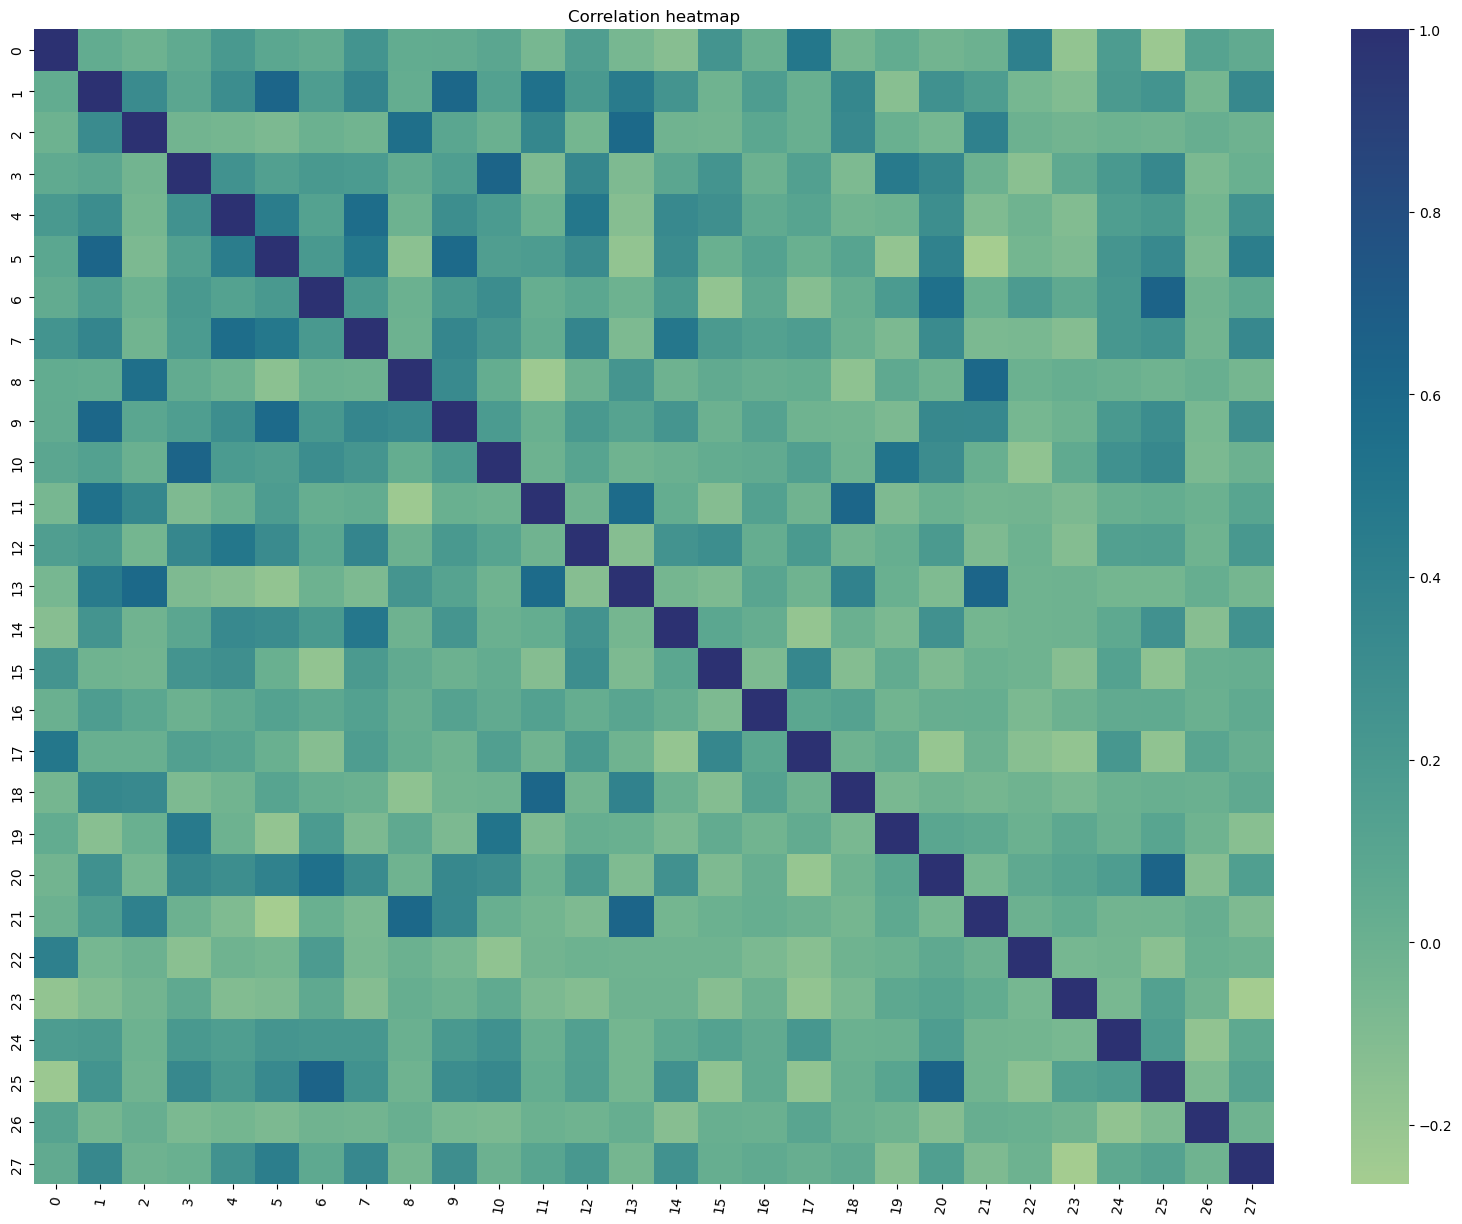

In [33]:
# Vẽ heatmap tương quan
corr_heatmap = X_train.select(kept_feature).corr()
fig, ax = plt.subplots(figsize = (20,15))
sns.heatmap(corr_heatmap,cmap= 'crest')
plt.title('Correlation heatmap')
plt.xticks(rotation= 80)

# 4. Regression

## 4.1 Lasso

C= 0.00055

In [139]:
model_1 = LogisticRegression(C= 0.00102, #0.00121, 
                             penalty= 'l1',
                             solver= 'saga',
                             random_state= 6969, 
                             max_iter= 300,
                             n_jobs= -1)
# Chuyển về NumPy
X_train_np = X_train.select(kept_feature).to_numpy()
y_train_np, y_test_np, y_oot_np = y_train.to_numpy().ravel(), y_test.to_numpy().ravel(), y_oot.to_numpy().ravel()

model_1.fit(X_train_np, y_train_np)

LogisticRegression(C=0.00102, max_iter=300, n_jobs=-1, penalty='l1',
                   random_state=6969, solver='saga')

In [140]:
coef = pd.DataFrame({"Feature":X_train.select(kept_feature).columns, "Coef": model_1.coef_[0]})
short_list = pd.concat([pd.DataFrame({"Feature":"Intercept", "Coef": [model_1.intercept_[0]]}), coef[coef['Coef'] != 0]])
short_list

,Feature,Coef
0,Intercept,-4.901587
0,MIN_N_PAYMENT_LAI,-0.409097
1,N_AVG_DEPOSIT_CBAL,-0.101758
2,N_AVG_DEPOSIT_6M,-0.248194
3,N_AVG_PYMTAMT_3M,-0.241337
4,AVG_LTV_MO,-0.046692
5,CBAL,-0.130762
6,REMAINING_DURATION_MAX,-0.119464
8,N_AVG_DD_6M,-0.093601
11,N_AVG_CD_CBAL,-0.170505


In [141]:
print("Number of variable after Lasso:", (len(short_list)-1), 'variables')

Number of variable after Lasso: 15 variables


In [145]:
params = model_1.get_params()

# Chuyển thành DataFrame
df_params = pd.DataFrame(list(params.items()), columns=['Feature', 'Coef']).replace('C','Model L2:')
df_params.replace('C','Model L2:', inplace= True)
for_export_2 = pd.concat([short_list,df_params[df_params['Feature'] == 'Model L2:']], ignore_index= True)

## 4.2. Best subset 

In [146]:
# Danh sách biến
features = short_list[short_list['Feature'] != 'Intercept']['Feature']

# Lưu kết quả mô hình
results = []
min_features = 8
max_features = 15

# Đếm tổng số tổ hợp để hiển thị tiến trình
total_combinations = sum(
    1 for r in range(min_features, min(max_features, len(features)) + 1)
    for _ in itertools.combinations(features, r)
)
total_combinations

16384

In [147]:
results = pd.DataFrame()

with tqdm(total= total_combinations, desc= "Niem tin chien thang") as pbar:
    i = 1
    for r in range(min_features, max_features + 1):
        for subset in itertools.combinations(features, r):
            subset = list(subset)  # Chuyển tuple về list
            
            # Chuyển về NumPy sau khi xử lý xong
            X_train_np= (X_train.select(subset).to_numpy())

            # Huấn luyện Logistic Regression
            model = LogisticRegression(max_iter= 100000, random_state= 6969)
            model.fit(X_train_np, y_train_np)

            # Dự đoán và tính toán chỉ số đánh giá
            y_train_prob = model.predict_proba(X_train_np)[:, 1]
            gini_train = 2 * roc_auc_score(y_train_np, y_train_prob) - 1

            if gini_train < 0.5:
                pass
            else:
                X_test_np, X_oot_np = (X_test.select(subset).to_numpy(),X_oot.select(subset).to_numpy())

                # Predict prob
                y_test_prob = model.predict_proba(X_test_np)[:, 1]
                y_oot_prob = model.predict_proba(X_oot_np)[:, 1]

                # Tính gini
                gini_test = 2 * roc_auc_score(y_test_np, y_test_prob) - 1
                gini_oot = 2 * roc_auc_score(y_oot_np, y_oot_prob) - 1
                
                # Chuyển thành dataframe
                coef = pd.DataFrame({"Feature":X_train.select(subset).columns, "Coef": model.coef_[0]})
                summary = pd.concat([pd.DataFrame({"Feature":"Intercept", "Coef": [model.intercept_[0]]}), coef[coef['Coef'] != 0]])
                summary['Gini train'] = gini_train
                summary['Gini test'] = gini_test
                summary['Gini out of time'] = gini_oot
                
                summary["Gini pass"] = (((summary['Gini train'] - summary['Gini out of time']) < 0.1) &
                                        ((summary['Gini test'] - summary['Gini out of time']) < 0.1))
                summary['Number of features'] = len(summary)
                summary['Model ID'] = i
                i += 1
  
                results = pd.concat([results, summary])
            pbar.update(1)

Niem tin chien thang: 100%|██████████| 16384/16384 [6:32:07<00:00,  1.44s/it]  


# 5. Print for report

In [150]:
results

""


In [151]:
dfs = {'Binning results': binning_table_1, 
       'Univariate and multivariate analysis': for_report, 
       'Correlation of kept features': corr_final, 
       'Lasso results': for_export_2, 
       'Model output': results}

# Ghi vào file Excel với tên sheet tùy chỉnh
with pd.ExcelWriter('./Modelling results.xlsx') as writer:
    for sheet_name, df in dfs.items():
        df.to_excel(writer, sheet_name=sheet_name, index=True)

print("Đã lưu file Excel với tên sheet tùy chỉnh thành công!")


Đã lưu file Excel với tên sheet tùy chỉnh thành công!


C:\Users\dungpt23\AppData\Roaming\Python\Python310\site-packages\openpyxl\workbook\child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


In [39]:
binning_table_1.to_excel('./Binning results.xlsx')
for_report.to_excel('./Univariate and multivariate analysis.xlsx')
corr_final.to_excel('./Correlation of kept features.xlsx')
for_export_2.to_excel('./Lasso results.xlsx')
results.to_excel('./Model output.xlsx')